In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</s}tyle>"))

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from pathlib import Path
import glob
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
import config
import random
from natsort import natsorted
import lfp
arm = 'UR5'


print('Using local setup')
WORKING_PATH = Path().absolute().parent
print(f'Working path: {WORKING_PATH}')
os.chdir(WORKING_PATH)
STORAGE_PATH = WORKING_PATH
print(f'Storage path: {STORAGE_PATH}')
UNITY = True


Using local setup
Working path: /catkin_ws/src/robotics/learning_from_play
Storage path: /catkin_ws/src/robotics/learning_from_play


In [3]:
if UNITY:
    TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in ["diverse"]]
    TEST_DATASET = "diverse_test" 

TEST_DATA_PATH = STORAGE_PATH/'data'/TEST_DATASET

In [4]:
physical_devices = tf.config.list_physical_devices(config.DEVICE)
if config.DEVICE is 'GPU':
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

<>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-4-87b2856da474>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if config.DEVICE is 'GPU':


IndexError: list index out of range

In [4]:
import lfp
import lfp.unity_utils
from lfp.unity_utils.messaging import UNITY_MAX_OBS_SIZE, UNITY_MAX_AG_SIZE

In [6]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature


def transform_states(data):

    obs, acts, achieved_goals, sequence_index, sequence_id = data['obs'], data['acts'], data['achieved_goals'],  data['sequence_index'], data['sequence_id']

    img = tf.io.read_file(data['shoulder_im_path'])
    gripper_img = tf.io.read_file(data['gripper_im_path'])

    return {
            'obs': obs,
            'acts': acts,
            'achieved_goals': achieved_goals,
            'sequence_index': sequence_index,
            'sequence_id': sequence_id,
            'img':img,
            'gripper_img':gripper_img,
            }

def transform_dataset(dataset):
  return dataset.map(transform_states, num_parallel_calls=4)


def serialise(data):
    
    obs, acts, achieved_goals, sequence_index, sequence_id, img, gripper_img = data['obs'], data['acts'], data['achieved_goals'], data['sequence_index'], data['sequence_id'], data['img'], data['gripper_img']
    
    obs = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(obs).numpy(),]))
    acts = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(acts).numpy(),]))
    achieved_goals = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(achieved_goals).numpy(),])) 
    sequence_index =  Feature(int64_list=Int64List(value=[sequence_index[0],]))
    sequence_id = Feature(int64_list=Int64List(value=[sequence_id[0],]))
    img = Feature(bytes_list=BytesList(value=[img.numpy(),]))
    gripper_img = Feature(bytes_list=BytesList(value=[gripper_img.numpy(),]))
    # img is already serialised because we never decode it!
    
    features = Features(feature={
                'obs': obs,
                'acts': acts,
                'achieved_goals': achieved_goals,
                'sequence_index': sequence_index,
                'sequence_id': sequence_id,
                'img': img,
                'gripper_img':gripper_img,
                })
    
    example = Example(features=features)
    
    return example.SerializeToString()


In [7]:
def decode_shoulder_img(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.reshape(image, [128,128, 3]) # explicit size needed for TPU
    return image

def decode_gripper_img(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.reshape(image, [64,64, 3]) # explicit size needed for TPU
    return image


def read_tfrecord(example):
    LABELED_TFREC_FORMAT = {
            'obs': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'acts': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'achieved_goals': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'sequence_index': tf.io.FixedLenFeature([], tf.int64),
            'sequence_id': tf.io.FixedLenFeature([], tf.int64),
            'img': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'gripper_img': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
    }
    data = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    obs = tf.io.parse_tensor(data['obs'], tf.float32) 
    acts = tf.io.parse_tensor(data['acts'], tf.float32) 
    achieved_goals = tf.io.parse_tensor(data['achieved_goals'], tf.float32)  
    sequence_index = tf.cast(data['sequence_index'], tf.int32) 
    sequence_id = tf.cast(data['sequence_id'], tf.int32) # this is meant to be 32 even though you serialize as 64
    
    img = decode_shoulder_img(data['img'])
    gripper_img = decode_gripper_img(data['gripper_img'])

    return {'obs' : obs, 
            'acts' : acts, 
            'achieved_goals' : achieved_goals, 
            'sequence_index' : sequence_index, 
            'sequence_id' : sequence_id,
            'img' : img,
            'gripper_img': gripper_img}

def load_tf_records(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    # check, does this ignore intra order or just inter order? Both are an issue!
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=1) # automatically interleaves reads from multiple files - keep it at 1 we need the order
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset



# Generate TF records for each tstep

In [8]:
import pybullet as p
def quat_to_rpy(vecs, idxs):
    result = []
    for i in range(0, len(vecs)):
        result.append(np.concatenate([vecs[i, :idxs[0]], np.array(p.getEulerFromQuaternion(vecs[i, idxs[0]:idxs[1]])), vecs[i, idxs[1]:]]))
    return np.vstack(result)



In [ ]:
paths =  TRAIN_DATA_PATHS 
# paths = [TEST_DATA_PATH] # TRAIN_DATA_PATHS # 

keys = ['obs','acts','achieved_goals']

num_records =0

for path in paths:
    obs_act_path = os.path.join(path, 'obs_act_etc/')
    
    try:
        os.makedirs(path/'tf_records')
    except:
        print('Files may already exist!')
        
    for demo in natsorted(os.listdir(obs_act_path)):
        print(obs_act_path+demo)
        
        dataset = {k:[] for k in keys+['sequence_index','sequence_id','im_path']}
        traj = np.load(obs_act_path+demo+'/data.npz')
        for k in keys:
            d = traj[k]
            if len(d.shape) < 2:
                d = np.expand_dims(d, axis = 1) # was N, should be N,1
            dataset[k] = d.astype(np.float32)
            
        L,D = dataset['obs'].shape
        if D < UNITY_MAX_OBS_SIZE and UNITY: # correct for old data which may have had less data 
            dataset['obs'] = np.concatenate([dataset['obs'], np.zeros([L, UNITY_MAX_OBS_SIZE-D])],-1).astype(np.float32)
            _, D_ag = dataset['achieved_goals'].shape
            dataset['achieved_goals'] = np.concatenate([dataset['achieved_goals'], np.zeros([L, UNITY_MAX_AG_SIZE-D_ag])],-1).astype(np.float32)
            print(dataset['obs'].shape, dataset['achieved_goals'].shape)
            
        timesteps = len(traj['obs'])
        dataset['obs_obj_rpy'] = quat_to_rpy(dataset['obs'], [10,14])
        dataset['achieved_goals_obj_rpy'] = quat_to_rpy(dataset['achieved_goals'], [3,7])
        dataset['sequence_index']= np.arange(timesteps, dtype=np.int32).reshape(-1, 1)
        dataset['sequence_id'] = np.full(timesteps, fill_value=int(demo), dtype=np.int32).reshape(-1, 1)
        dataset['im_path'] = [str(path) for i in range(0,timesteps)]
        dataset['shoulder_im_path'] = [str(s) + '/states_and_ims/'+str(dataset['sequence_id'][i][0]) + '/ims/'+str(dataset['sequence_index'][i][0])+'_shoulder.jpg' for i,s in enumerate(dataset['im_path'])]
        dataset['gripper_im_path'] = [str(s) + '/states_and_ims/'+str(dataset['sequence_id'][i][0]) + '/ims/'+str(dataset['sequence_index'][i][0])+'_gripper.jpg' for i,s in enumerate(dataset['im_path'])]
        full_dataset = tf.data.Dataset.from_tensor_slices(dataset)
        full_dataset = transform_dataset(full_dataset)
        it = iter(full_dataset)

        # Write the records to a file. Shouldn't need to slice it up - shuffle size is large enough. to randomize
        with tf.io.TFRecordWriter(str(path/'tf_records/')+f"/{int(demo)}.tfrecords") as file_writer:
            for data in it:
                byte_stream = serialise(data)
                file_writer.write(byte_stream)


Files may already exist!
/catkin_ws/src/robotics/learning_from_play/data/envHz25/obs_act_etc/0
(10003, 35) (10003, 29)
/catkin_ws/src/robotics/learning_from_play/data/envHz25/obs_act_etc/1
(10003, 35) (10003, 29)
/catkin_ws/src/robotics/learning_from_play/data/envHz25/obs_act_etc/2
(249, 35) (249, 29)
/catkin_ws/src/robotics/learning_from_play/data/envHz25/obs_act_etc/3
(2508, 35) (2508, 29)
/catkin_ws/src/robotics/learning_from_play/data/envHz25/obs_act_etc/4
(10003, 35) (10003, 29)
/catkin_ws/src/robotics/learning_from_play/data/envHz25/obs_act_etc/5
(6551, 35) (6551, 29)
/catkin_ws/src/robotics/learning_from_play/data/envHz25/obs_act_etc/6
(10004, 35) (10004, 29)
/catkin_ws/src/robotics/learning_from_play/data/envHz25/obs_act_etc/7
(10003, 35) (10003, 29)
/catkin_ws/src/robotics/learning_from_play/data/envHz25/obs_act_etc/8
(304, 35) (304, 29)
/catkin_ws/src/robotics/learning_from_play/data/envHz25/obs_act_etc/9
(10002, 35) (10002, 29)
/catkin_ws/src/robotics/learning_from_play/data

In [55]:
read_tfrecord(byte_stream)

{'obs': <tf.Tensor: shape=(35,), dtype=float32, numpy=
 array([-0.24308231,  0.22951789,  0.33869115,  1.2966044 , -1.3518993 ,
        -0.4532039 ,  0.9147396 , -0.18065019,  0.06104948,  0.40860254,
        -0.70344526,  0.07122915, -0.07123191, -0.70357466,  0.        ,
         0.        ,  0.        ,  0.08397162, -0.98243684,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       dtype=float32)>,
 'acts': <tf.Tensor: shape=(7,), dtype=float32, numpy=
 array([-0.2290763 ,  0.1892935 ,  0.32730073,  1.4055648 , -1.3654934 ,
        -0.45534453,  0.9991766 ], dtype=float32)>,
 'achieved_goals': <tf.Tensor: shape=(28,), dtype=float32, numpy=
 array([-0.18065019,  0.06104948,  0.40860254, -0.70344526,  0.07122915,
        -0.07123191, -0.70357466,  0.        ,  0.        ,  0.        ,
         0.083971

In [8]:
gsutil cp *.tfrecords gs://lfp_europe_west4_a/data/Unity/envHz25/tf_records

SyntaxError: invalid syntax (<ipython-input-8-385b1bfc26a4>, line 1)

In [42]:
record_paths = []
for p in TRAIN_DATA_PATHS:#[TEST_DATA_PATH]:
    record_paths += glob.glob(str(p/'tf_records/*.tfrecords'))
    
record_paths

['C:\\Users\\sholt\\Desktop\\robotics\\learning_from_play\\data\\envHz25\\tf_records\\0.tfrecords',
 'C:\\Users\\sholt\\Desktop\\robotics\\learning_from_play\\data\\envHz25\\tf_records\\1.tfrecords',
 'C:\\Users\\sholt\\Desktop\\robotics\\learning_from_play\\data\\envHz25\\tf_records\\2.tfrecords']

In [46]:
d =load_tf_records([record_paths], ordered=True)#['/home/sholto/Desktop/AI/learning_from_play/data/UR5_high_transition/tf_records/21.tfrecords'], ordered=True) #record_paths
print(d)
d = iter(d)

<ParallelMapDataset shapes: {obs: <unknown>, acts: <unknown>, achieved_goals: <unknown>, sequence_index: (), sequence_id: (), img: (128, 128, 3), gripper_img: (64, 64, 3)}, types: {obs: tf.float32, acts: tf.float32, achieved_goals: tf.float32, sequence_index: tf.int32, sequence_id: tf.int32, img: tf.uint8, gripper_img: tf.uint8}>


In [47]:
%%time
from IPython.display import display, clear_output
for i in range(0,10000):
    b = d.next()
    
    clear_output(wait=True)
    
    fig = plt.imshow(b['img'])
    plt.show()
    print( b['sequence_index'], b['sequence_id'])
    

KeyboardInterrupt: 

# Generate language labelleds for indices


In [38]:
path =  TEST_DATA_PATH #   TRAIN_DATA_PATHS[0] #
keys = ['obs','acts','achieved_goals']
obs_act_path = os.path.join(path, 'obs_act_etc/')
directories = natsorted(os.listdir(obs_act_path))
print(path)

/catkin_ws/src/robotics/learning_from_play/data/diverse_test


In [23]:
def get_dataset(directories, index=None):
    if index == None:
        demo = random.choice(directories)
    else:
        demo = str(index)
    dataset = {k:[] for k in keys+['sequence_index','sequence_id','im_path']}
    traj = np.load(obs_act_path+demo+'/data.npz')
    for k in keys:
        d = traj[k]
        if len(d.shape) < 2:
            d = np.expand_dims(d, axis = 1) # was N, should be N,1
        dataset[k] = d.astype(np.float32)
    timesteps = len(traj['obs'])
    dataset['sequence_index']= np.arange(timesteps, dtype=np.int32).reshape(-1, 1)
    dataset['sequence_id'] = np.full(timesteps, fill_value=int(demo), dtype=np.int32).reshape(-1, 1)
    dataset['im_path'] = [str(path) for i in range(0,timesteps)]
    dataset['shoulder_im_path'] = [str(s) + '/states_and_ims/'+str(dataset['sequence_id'][i][0]) + '/ims/'+str(dataset['sequence_index'][i][0])+'_shoulder.jpg' for i,s in enumerate(dataset['im_path'])]
    dataset['gripper_im_path'] = [str(s) + '/states_and_ims/'+str(dataset['sequence_id'][i][0]) + '/ims/'+str(dataset['sequence_index'][i][0])+'_gripper.jpg' for i,s in enumerate(dataset['im_path'])]
    return dataset

def get_random_sub_trajectory(dataset, traj_max=50, traj_min=25):
    d_len = len(dataset['obs'])
    start = random.randint(0,d_len-traj_max)
    end = start + random.randint(traj_min, traj_max)
    images = dataset['shoulder_im_path'][start:end]
    
    return {'traj': dataset['sequence_id'][0][0], 'start': start, 'end':end}, images

In [24]:
import skimage.io as io

def play_trajectory(images):
    for i, im in enumerate(images):
        if i % 5 == 0:
            clear_output(wait=True)
            fig = plt.imshow(io.imread(im))
            plt.show()
        


In [25]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [41]:
tag_matching = {
0: 'button',
1: 'cupboard door left',
2: 'cupboard door right',
3: 'drawer in',
4: 'drawer out',
5: 'block in/out drawer',
6: 'block in/out cupboard',
7: 'block',
8: 'block + shelf',
9: 'multi_object',
}

filename = 'labels'
tagging = True
if tagging: filename = 'tagged_labels' 

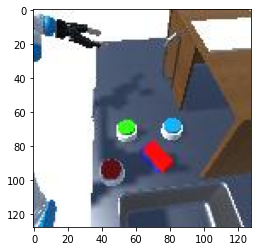

 502 Label: q
Saving


In [29]:
from IPython.display import display, clear_output

try:
    labels = list(np.load(path/f'{filename}.npz', allow_pickle=True)['labels'])
except:
    labels = []
    
while(1):
    dataset = get_dataset(directories)
    key, images = get_random_sub_trajectory(dataset)
    play_trajectory(images)
    val = input(f" {len(labels)} Label: ")
    while val in ['r']:
            play_trajectory(images)
            val = input("Label: ")
            
    if val == 's':
        pass
    elif val == 'q':
        print(f'Saving')
        np.savez(path/filename, labels=labels, allow_objects=True)
        break
    else:
        if tagging:
            tag = input("Tag: ")
            labels.append({'indices':key, 'label':val, 'tag':tag_matching[int(tag)]})
        else:
            labels.append({'indices':key, 'label':val, 'tag': ""})
            
        np.savez(path/filename, labels=labels, allow_objects=True)
    
    
    
    

In [33]:


module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)


embed = hub.KerasLayer(str(STORAGE_PATH)+'/saved_models/universal_sentence_encoder')

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [15]:

# embeddings = embed(["A long sentence.", "single-word", "http://example.com"])
# print(embeddings.shape, embeddings.dtype)

# Generate language labelled tf records
To be zipped with main dataset

In [42]:
indices_and_labels = list(np.load(path/f'{filename}.npz', allow_pickle=True)['labels'])
indices_and_labels

[{'indices': {'traj': 0, 'start': 102, 'end': 139},
  'label': 'lift up the blue block ',
  'tag': 'block'},
 {'indices': {'traj': 0, 'start': 773, 'end': 803},
  'label': 'take the red block down from the cupboard',
  'tag': 'block'},
 {'indices': {'traj': 0, 'start': 117, 'end': 145},
  'label': 'put the blue block to the left of the red one',
  'tag': 'block'},
 {'indices': {'traj': 3, 'start': 393, 'end': 423},
  'label': 'press the red button',
  'tag': 'button'},
 {'indices': {'traj': 2, 'start': 1848, 'end': 1891},
  'label': 'get the red block',
  'tag': 'block'},
 {'indices': {'traj': 3, 'start': 1399, 'end': 1432},
  'label': 'move the red block to the other side of the buttons upright',
  'tag': 'block'},
 {'indices': {'traj': 0, 'start': 43, 'end': 80},
  'label': 'move the door left and prepare to grasp the blue block',
  'tag': 'multi_object'},
 {'indices': {'traj': 3, 'start': 675, 'end': 705},
  'label': 'press the red button',
  'tag': 'button'},
 {'indices': {'traj': 

In [43]:
max_len = 50
shoulder_im_dim = 128
gripper_im_dim = 64
use_gripper_imgs = True
i = 1

def get_traj(i, indices_and_labels, directories, max_len=50, shoulder_im_dim=128, gripper_im_dim=64, use_gripper_imgs = True):
    
    indices, label, tag = indices_and_labels[i]['indices'], indices_and_labels[i]['label'], indices_and_labels[i]['tag'] 
    traj, start, end = indices['traj'], indices['start'], indices['end']
    dataset = get_dataset(directories, traj)
    # obs (end-start, 19/35) depending on how many objects and stuff
    obs = dataset['obs'][start:end]
    # acts (end-start, 7)
    acts = dataset['acts'][start:end]
    # goals (end-start, 12/28) depending on how many objects and stuff
    goals = np.tile(dataset['achieved_goals'][np.newaxis, end], [end-start,1])
    L,D = obs.shape
    if D < UNITY_MAX_OBS_SIZE and UNITY: # correct for old data which may have had less data 
        obs = np.concatenate([obs, np.zeros([L, UNITY_MAX_OBS_SIZE-D])],-1).astype(np.float32)
        _, D_ag = goals.shape
        goals = np.concatenate([goals, np.zeros([L, UNITY_MAX_AG_SIZE-D_ag])],-1).astype(np.float32)
        
    
    # seq_lens (1,)
    seq_lens = end-start
    # dataset_path (end-start)
    dataset_path = np.array([traj]*seq_lens)
    # tstep_idxs (end-start)
    tsep_idxs = np.arange(start, end)

    # imgs (end-start, 128, 128, 3)
    img_paths = dataset['shoulder_im_path'][start:end]
    shoulder_imgs = np.stack([tf.reshape(tf.image.decode_jpeg(tf.io.read_file(p).numpy(), channels=3), [shoulder_im_dim, shoulder_im_dim, 3]) for p in img_paths])
    # (end-start, 64, 64, 3)
    gripper_img_paths = dataset['gripper_im_path'][start:end]
    gripper_imgs = np.stack([tf.reshape(tf.image.decode_jpeg(tf.io.read_file(p).numpy(), channels=3), [gripper_im_dim, gripper_im_dim, 3]) for p in gripper_img_paths])
    # goal_imgs (end-start, 128, 128, 3)
    goal_imgs = tf.reshape(tf.image.decode_jpeg(tf.io.read_file(dataset['shoulder_im_path'][end]).numpy(), channels=3), [shoulder_im_dim, shoulder_im_dim, 3])
    # proprioceptive_features (end-start, 7)
    proprioceptive_features = obs[:, :7]

    masks = tf.ones([end-start])

    def pad(element, max_len, seq_len):
        padding = [[0,0] for i in range(0,len(element.shape))] # create padding the same dim as the tensor
        padding[0] = [0,max_len-seq_len] # create padding for the time dimension
        return tf.pad(element, padding) # pad and add a new axis

    trajectory = { 'obs':obs,
                  'acts':acts,
                  'goals':goals,
                  'masks':masks,
                  'imgs':shoulder_imgs,
                  'gripper_imgs':gripper_imgs,
                  'proprioceptive_features':proprioceptive_features}

    trajectory = {k:pad(v, max_len, seq_lens) for k,v in trajectory.items()}

    trajectory['seq_lens'] = seq_lens
    trajectory['goal_imgs'] = goal_imgs
    trajectory['label'] = label
    trajectory['label_embedding'] = np.squeeze(embed([label])) # # 512
    trajectory['tag'] = tag
    
    return trajectory


from lfp.data import serialise_traj, labelled_dl


In [44]:
from tqdm import tqdm
save_path = str(path/'tf_records')+f"/{filename}.tfrecords"
with tf.io.TFRecordWriter(save_path) as file_writer:
    print(save_path)
    for i in tqdm(range(0,len(indices_and_labels))):
        t = get_traj(i, indices_and_labels, directories)
        byte_stream = serialise_traj(t)
        file_writer.write(byte_stream)

  0%|          | 0/72 [00:00<?, ?it/s]

/catkin_ws/src/robotics/learning_from_play/data/diverse_test/tf_records/tagged_labels.tfrecords


100%|██████████| 72/72 [01:10<00:00,  1.02it/s]


In [1]:
# gsutil cp tagged_labels.tfrecords gs://lfp_europe_west4_a/data/Unity/envHz25_test/tf_records

SyntaxError: invalid syntax (<ipython-input-1-30a32a35b38d>, line 1)

In [38]:
t

{'obs': <tf.Tensor: shape=(40, 35), dtype=float64, numpy=
 array([[-0.52000755,  0.31237245,  0.50242865, ...,  0.        ,
          0.        ,  0.        ],
        [-0.49863088,  0.32757893,  0.50924504, ...,  0.        ,
          0.        ,  0.        ],
        [-0.48953617,  0.33078688,  0.51263571, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]])>,
 'acts': <tf.Tensor: shape=(40, 7), dtype=float32, numpy=
 array([[-4.4245946e-01,  3.5323608e-01,  5.3183746e-01,  4.4148123e-01,
         -2.9748106e-01, -8.0959298e-02,  0.0000000e+00],
        [-3.9988723e-01,  3.5825729e-01,  5.5245632e-01,  4.1681138e-01,
         -3.1947926e-01, -2.5192691e-02,  0.0000000e

In [40]:
d = serialise_traj(t)

# Random inspection stuff

In [41]:
lfp.data.read_traj_tfrecord(d)

InvalidArgumentError: Type mismatch between parsed tensor (double) and dtype (float) [Op:ParseTensor]

In [54]:
iter(ds).next()

{'obs': <tf.Tensor: shape=(12, 40, 19), dtype=float32, numpy=
 array([[[-0.6416209 ,  0.29491517,  0.35553998, ...,  0.        ,
           0.85619795, -0.97765356],
         [-0.6311363 ,  0.29619896,  0.35903627, ...,  0.        ,
           0.85619795, -0.97765356],
         [-0.62822795,  0.2993713 ,  0.36453468, ...,  0.        ,
           0.85619795, -0.97765356],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],
 
        [[-0.7489886 ,  0.23238343,  0.0291406 , ...,  0.        ,
           1.        , -0.98127216],
         [-0.74572456,  0.25275022,  0.04962865, ...,  0.        ,
           1.        , -0.98127216],
         [-0.73729974,  0.28391877,  0.08796716, ...,  0.        ,
           1.        ,

In [213]:
traj = read_tfrecord(serialised)['goal_imgs'].shape

In [53]:
labelled_dl = lfp.data.labelled_dl(batch_size=12)
labelled_ds = labelled_dl.extract([TEST_DATA_PATH])
ds = iter(labelled_dl.load(labelled_ds))

In [11]:
import tensorflow as tf
import numpy as np
o = tf.tensor(np.array([1,2,3,45]))
tf.concat([o,o[5:]], 0)

AttributeError: module 'tensorflow' has no attribute 'tensor'

In [10]:
o[5:].type

AttributeError: 'numpy.ndarray' object has no attribute 'type'

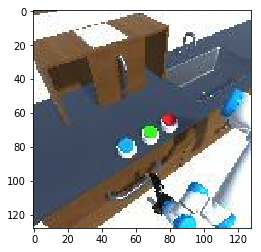

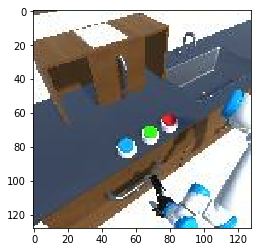

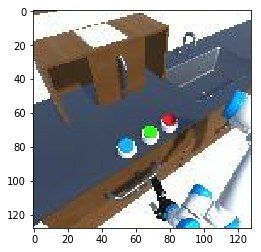

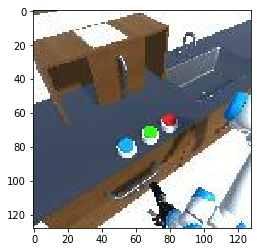

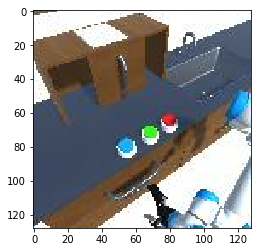

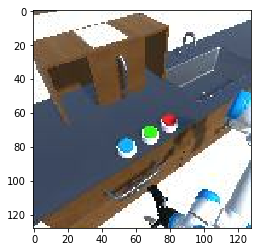

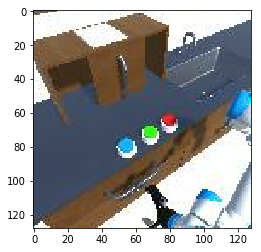

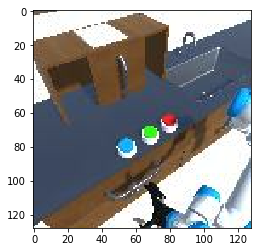

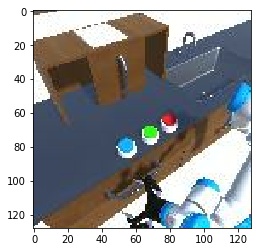

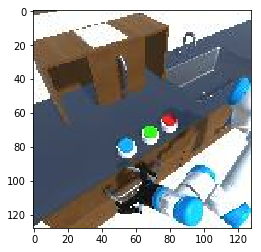

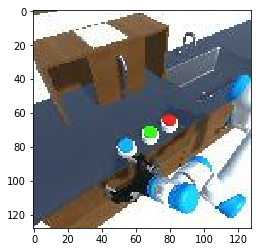

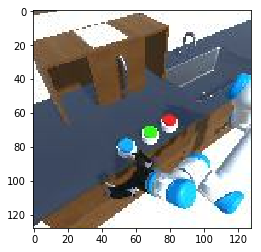

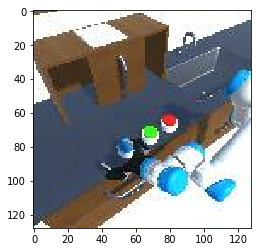

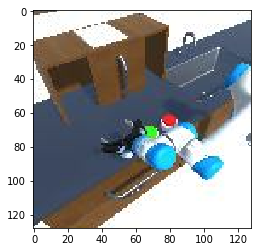

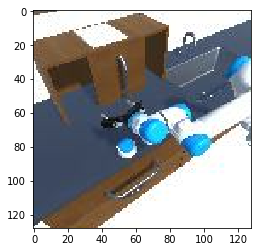

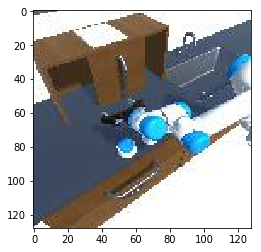

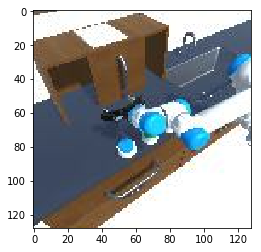

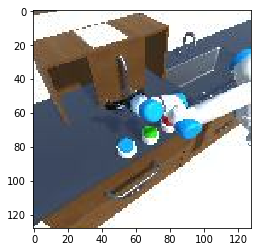

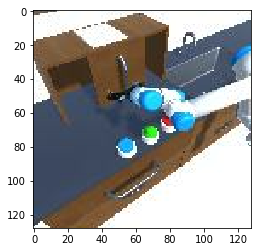

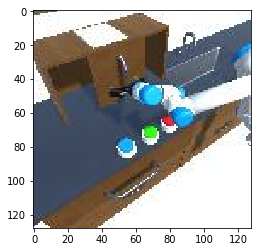

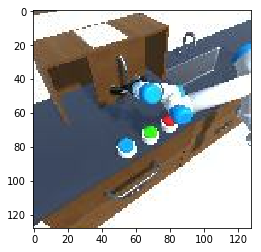

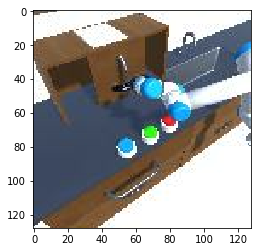

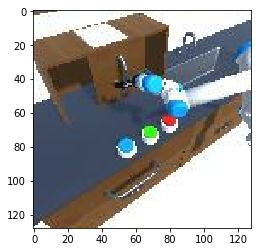

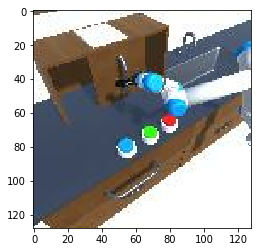

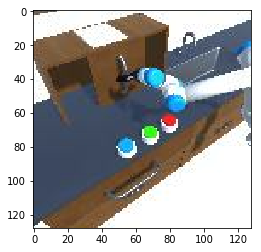

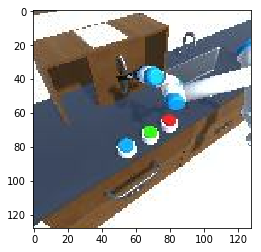

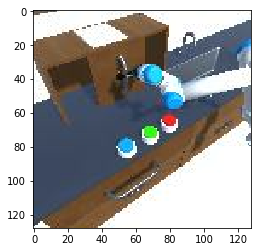

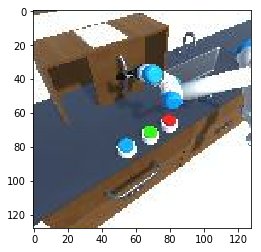

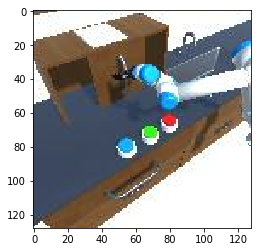

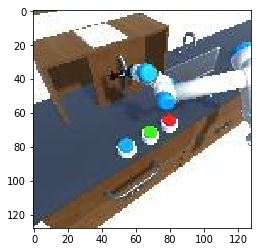

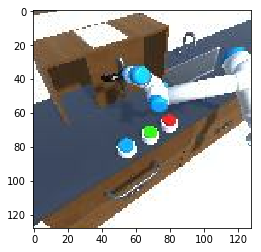

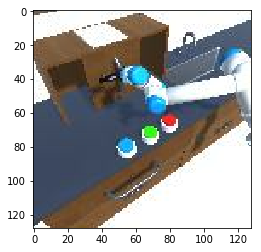

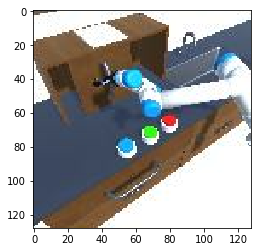

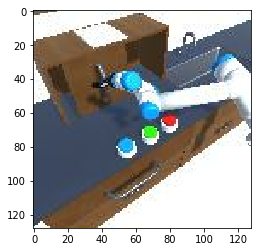

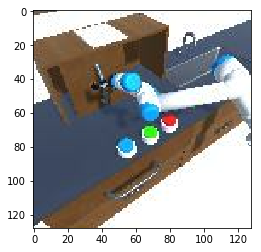

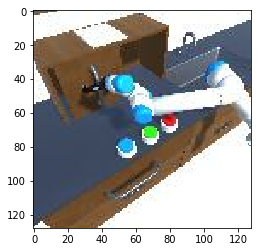

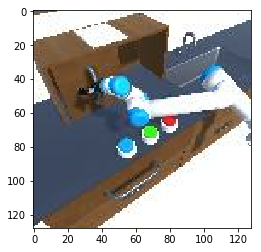

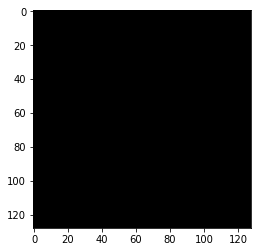

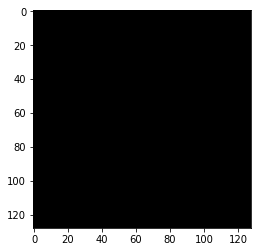

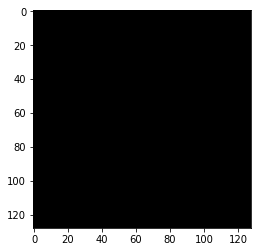

In [212]:
for i in range(0,40):
    plt.imshow(traj['imgs'][0, i,:,:,:])
    plt.show()

In [211]:
traj['imgs'][0, 0,:,:,:]

<tf.Tensor: shape=(128, 128, 3), dtype=uint8, numpy=
array([[[110, 101,  92],
        [105,  96,  87],
        [102,  93,  84],
        ...,
        [255, 255, 250],
        [255, 255, 250],
        [248, 247, 242]],

       [[101,  92,  83],
        [112, 103,  94],
        [109, 100,  91],
        ...,
        [246, 247, 242],
        [255, 254, 250],
        [255, 255, 251]],

       [[116, 109, 101],
        [105,  98,  90],
        [ 94,  87,  79],
        ...,
        [254, 255, 253],
        [255, 255, 253],
        [240, 242, 239]],

       ...,

       [[ 71,  81,  90],
        [ 49,  58,  65],
        [ 74,  79,  83],
        ...,
        [244, 255, 255],
        [255, 254, 255],
        [255, 250, 253]],

       [[ 60,  69,  74],
        [249, 255, 255],
        [251, 255, 255],
        ...,
        [235, 255, 255],
        [251, 255, 250],
        [255, 255, 244]],

       [[248, 255, 255],
        [240, 248, 250],
        [248, 252, 251],
        ...,
        [230, 255, 25

# Once off data stuff

In [32]:
# # pip install Pillow if you don't already have it

# # import image utilities
# from PIL import Image

# # import os utilities
# import os

# # define a function that rotates images in the current directory
# # given the rotation in degrees as a parameter
# def rotateImages(rotationAmt, d):
#   # for each image in the current directory
#   for image in d:
#     # open the image
#     img = Image.open(image)
#     # rotate and save the image with the same filename
#     print(image)
#     img.rotate(rotationAmt).save(image)
#     # close the image
#     img.close()

    
# paths =  [TEST_DATA_PATH]
# keys = ['obs','acts','achieved_goals']


# for path in paths:
#     obs_act_path = os.path.join(path, 'obs_act_etc/')
    
#     for demo in natsorted(os.listdir(obs_act_path)):
#         print(obs_act_path+demo)
#         dataset = {k:[] for k in keys+['sequence_index','sequence_id','im_path']}
#         traj = np.load(obs_act_path+demo+'/data.npz')
#         for k in keys:
#             d = traj[k]
#             if len(d.shape) < 2:
#                 d = np.expand_dims(d, axis = 1) # was N, should be N,1
#             dataset[k] = d.astype(np.float32)
#         timesteps = len(traj['obs'])
#         dataset['sequence_index']= np.arange(timesteps, dtype=np.int32).reshape(-1, 1)
#         dataset['sequence_id'] = np.full(timesteps, fill_value=int(demo), dtype=np.int32).reshape(-1, 1)
#         dataset['im_path'] = [str(path) for i in range(0,timesteps)]
#         dataset['gripper_im_path'] = [str(s) + '/states_and_ims/'+str(dataset['sequence_id'][i][0]) + '/ims/'+str(dataset['sequence_index'][i][0])+'_gripper.jpg' for i,s in enumerate(dataset['im_path'])]
#         rotateImages(-90, dataset['gripper_im_path'])

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test\obs_act_etc/0
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/0_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/6_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/7_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/8_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/9_gripper.jpg
C:\Users\sholt\Deskt

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/183_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/184_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/185_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/186_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/187_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/188_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/189_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/190_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/191_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/192_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/291_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/292_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/293_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/294_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/295_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/296_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/297_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/298_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/299_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/300_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/395_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/396_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/397_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/398_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/399_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/400_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/401_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/402_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/403_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/404_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/499_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/500_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/501_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/502_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/503_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/504_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/505_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/506_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/507_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/508_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/596_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/597_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/598_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/599_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/600_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/601_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/602_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/603_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/604_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/605_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/738_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/739_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/740_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/741_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/742_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/743_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/744_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/745_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/746_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/747_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/848_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/849_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/850_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/851_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/852_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/853_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/854_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/855_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/856_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/857_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1034_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1035_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1036_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1037_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1038_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1039_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1040_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1041_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1042_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1043_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1157_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1158_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1159_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1160_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1161_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1162_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1163_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1164_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1165_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1166_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1348_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1349_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1350_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1351_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1352_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1353_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1354_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1355_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1356_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1357_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1530_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1531_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1532_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1533_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1534_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1535_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1536_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1537_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1538_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1539_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1715_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1716_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1717_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1718_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1719_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1720_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1721_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1722_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1723_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1724_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1829_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1830_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1831_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1832_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1833_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1834_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1835_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1836_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1837_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1838_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1933_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1934_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1935_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1936_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1937_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1938_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1939_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1940_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1941_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/1942_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2030_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2031_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2032_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2033_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2034_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2035_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2036_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2037_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2038_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2039_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2289_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2290_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2291_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2292_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2293_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2294_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2295_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2296_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2297_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2298_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2439_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2440_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2441_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2442_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2443_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2444_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2445_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2446_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2447_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2448_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2591_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2592_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2593_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2594_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2595_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2596_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2597_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2598_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2599_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2600_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2758_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2759_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2760_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2761_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2762_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2763_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2764_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2765_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2766_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2767_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2893_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2894_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2895_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2896_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2897_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2898_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2899_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2900_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2901_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2902_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2991_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2992_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2993_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2994_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2995_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2996_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2997_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2998_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/2999_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3000_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3165_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3166_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3167_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3168_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3169_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3170_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3171_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3172_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3173_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3174_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3347_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3348_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3349_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3350_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3351_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3352_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3353_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3354_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3355_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3356_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3445_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3446_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3447_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3448_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3449_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3450_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3451_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3452_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3453_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3454_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3547_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3548_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3549_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3550_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3551_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3552_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3553_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3554_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3555_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3556_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3647_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3648_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3649_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3650_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3651_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3652_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3653_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3654_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3655_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3656_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3743_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3744_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3745_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3746_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3747_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3748_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3749_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3750_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3751_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3752_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3832_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3833_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3834_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3835_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3836_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3837_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3838_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3839_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3840_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3841_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3998_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/3999_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4000_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4001_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4002_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4003_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4004_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4005_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4006_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4007_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4088_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4089_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4090_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4091_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4092_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4093_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4094_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4095_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4096_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4097_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4194_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4195_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4196_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4197_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4198_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4199_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4200_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4201_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4202_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4203_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4290_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4291_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4292_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4293_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4294_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4295_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4296_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4297_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4298_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4299_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4444_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4445_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4446_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4447_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4448_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4449_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4450_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4451_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4452_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4453_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4603_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4604_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4605_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4606_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4607_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4608_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4609_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4610_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4611_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4612_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4708_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4709_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4710_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4711_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4712_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4713_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4714_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4715_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4716_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4717_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4816_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4817_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4818_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4819_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4820_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4821_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4822_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4823_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4824_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4825_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4923_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4924_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4925_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4926_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4927_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4928_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4929_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4930_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4931_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/4932_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5031_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5032_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5033_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5034_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5035_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5036_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5037_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5038_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5039_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5040_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5141_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5142_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5143_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5144_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5145_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5146_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5147_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5148_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5149_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/states_and_ims/0/ims/5150_gripper.jpg
C:\Users\sholt\Desktop\learning_from_play\data\UR5_test/stat

In [92]:
for i, (k,v) in enumerate(data.items()):
    print(v == b[i])
    

tf.Tensor(
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True], shape=(18,), dtype=bool)
tf.Tensor([ True  True  True  True  True  True  True], shape=(7,), dtype=bool)
tf.Tensor([ True  True  True  True  True  True  True  True  True  True  True], shape=(11,), dtype=bool)
tf.Tensor([ True  True  True  True  True  True  True  True], shape=(8,), dtype=bool)
tf.Tensor([ True  True  True  True  True  True], shape=(6,), dtype=bool)
tf.Tensor([ True  True  True  True  True  True  True  True], shape=(8,), dtype=bool)
tf.Tensor([ True  True  True  True  True  True  True], shape=(7,), dtype=bool)
tf.Tensor([ True  True  True  True  True  True], shape=(6,), dtype=bool)
tf.Tensor(
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True], shape=(19,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dty

InvalidArgumentError: cannot compute Equal as input #1(zero-based) was expected to be a string tensor but is a float tensor [Op:Equal]

In [94]:
obs, acts, achieved_goals, joint_poses, target_poses, acts_quat, acts_rpy_rel, velocities, obs_quat, gripper_proprioception, sequence_index, sequence_id,img = b 

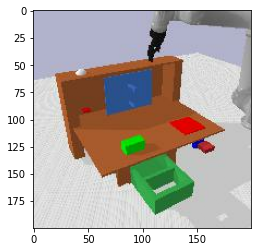

In [96]:
plt.imshow(img)